In [1]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.functional_models import Sersic2D, Gaussian2D
from reproject import reproject_interp
from astropy.cosmology import FlatLambdaCDM
from pylab import contour, savefig
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.visualization import LogStretch, ImageNormalize
import math
import emcee
from scipy.optimize import minimize
import scipy.special as sp
from scipy import integrate
from scipy.interpolate import interp2d
from scipy.stats import mode
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from importlib import reload
import corner
import KnotFitClass as kf
from IPython.display import display, Math

In /home/brian/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/brian/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/brian/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/brian/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/brian/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
indir = 'whl0137'
imfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_drz.fits' 
imfile = os.path.join(indir,imfile)

modeldir = 'whl0137/lens_modelling/zitrin/TosendBrianWithMinimization/models/imv2_125only/final_f012_5kstep'
dflx = os.path.join(modeldir, 'alpha_x_whl0137_6p2_20210206_LTM_Gc_2HST.fits')
dfly = os.path.join(modeldir, 'alpha_y_whl0137_6p2_20210206_LTM_Gc_2HST.fits')
magnif = os.path.join(modeldir, 'magnif-inv_whl0137_6p2_20210206_LTM_Gc.fits')

In [3]:
def Dds_Ds(zl, zs):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    Dds = cosmo.angular_diameter_distance_z1z2(zl, zs)
    Ds  = cosmo.angular_diameter_distance_z1z2(0 , zs)
    return Dds / Ds


def ddy(A):
    """Numerical derivative: 2nd-order
    output array will have dimentions (N-2, N-2)"""
    dAdy1 = (A[2:] - A[:-2]) / 2.
    dAdy2 = (-A[4:] + 8*A[3:-1] - 8*A[1:-3] + A[:-4]) / 12.
    dAdy1[1:-1,:] = dAdy2
    dAdy1 = dAdy1[:,1:-1]
    return dAdy1

def ddx(A):
    dAdx = ddy(A.T).T
    return dAdx

# Results have dimensions (N-2, N-2)
# Add zero padding to restore to (N, N) HST image pixel grid
def zeropad(data):
    ny, nx = data.shape
    padded = np.zeros((ny+2, nx+2))
    padded[1:-1,1:-1] = data
    return padded

def pix_to_pc(rpix, z):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    DA = cosmo.angular_diameter_distance_z1z2(0 , z).value * 10**6 #returns in pc
    pixSize = 0.06 #HST WFC3 pixel size
    theta = rpix * pixSize #arcsec
    theta = theta / ((180. / np.pi) * 3600) #radian
    r_pc = theta * DA #phys
    return r_pc


In [4]:
imhdu = fits.open(imfile)
imdata = imhdu[0].data

reproject = False

if reproject:
    hdudeflx = fits.open(dflx)
    hdudefly = fits.open(dfly)
    #reproject deflection fields to HST WCS pixels
    deflxHST, footprint = reproject_interp(hdudeflx[0], imhdu[0].header)
    deflyHST, footprint = reproject_interp(hdudefly[0], imhdu[0].header)

    # commented out transform for LTM models, which return in pixels already
    ax = deflxHST #/ 0.06 # arcsec -> pixels
    ay = deflyHST #/ 0.06 # arcsec -> pixels
    
    # rescale to appropriate redshift
    zsource_in = 6.2
    zsource_out = 6.2
    zlens = 0.566

    if zsource_in == 0: #if already scaled to Dls/Ds = 0
        Dds_Ds_out = self.Dds_Ds(zlens, zsource_out)

        ax = ax * Dds_Ds_out
        ay = ay * Dds_Ds_out
    elif zsource_in == zsource_out: # if no transformation required
        pass
    else: # if scaled to some redshift
        Dds_Ds_in  = self.Dds_Ds(zlens, zsource_in)
        Dds_Ds_out = self.Dds_Ds(zlens, zsource_out)

        ax = ax / Dds_Ds_in * Dds_Ds_out
        ay = ay / Dds_Ds_in * Dds_Ds_out
else:
    ax = fits.open(dflx)[0].data
    ay = fits.open(dfly)[0].data

In [5]:
if reproject:
    axx = ddx(ax)
    ayy = ddy(ay)
    
    axy = ddy(ax)
    ayx = ddx(ay)
    
    kappa  = 0.5 * (axx + ayy)
    gamma1 = 0.5 * (axx - ayy)
    gamma2 = axy
    gamma  = np.sqrt(gamma1**2 + gamma2**2)
    
    kappa = zeropad(kappa)
    gamma = zeropad(gamma)
    
    magnifinv = (1-kappa)**2 - gamma**2

    # save to file?
    outfile = None
    if outfile:
        magnif = 1. / magnifinv
        hdumag = fits.PrimaryHDU(magnif)
        hdumag.header = imhdu[0].header
        hdumag.writeto(outfile)
else:
    magnifinv = fits.open(magnif)[0].data

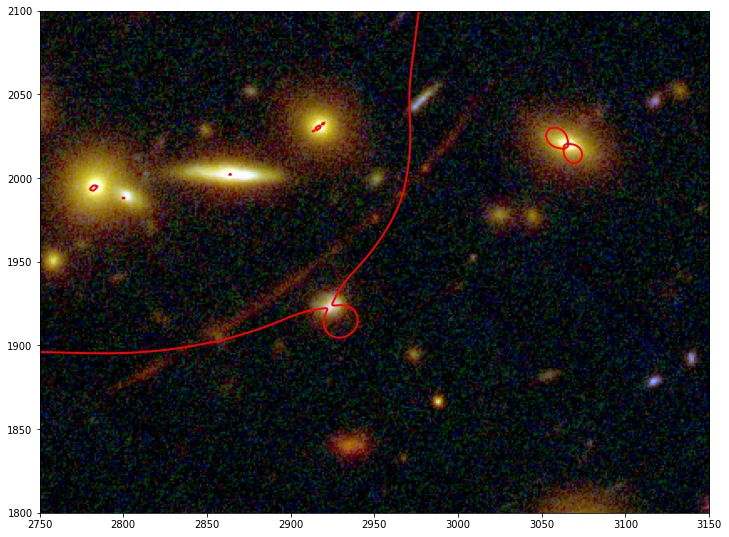

In [6]:
Image.MAX_IMAGE_PIXELS = None
infile = 'whl0137-08_new_bright.png'
infile = os.path.join(indir, infile)
im = Image.open(infile)
im = im.transpose(Image.FLIP_TOP_BOTTOM)

# Define coordinate grid
yy, xx = np.indices(magnifinv.shape)

plt.figure(figsize=(12, 12.5))
plt.imshow(im, origin='lower')
#xlo, xhi = 1800, 3200
#ylo, yhi = 1700, 3000
xlo, xhi = 2750, 3150 #whl0137
ylo, yhi = 1800, 2100
#xlo, xhi = 2850, 2975 #whl0137
#ylo, yhi = 1900, 1995
plt.xlim(xlo, xhi)
plt.ylim(ylo, yhi)
con = plt.contour(xx, yy, magnifinv, [0], colors='r', linewidths=2)

In [7]:
# Source position grid
xss = xx - ax
yss = yy - ay

In [8]:
reload(kf)
# define galaxy model
model = kf.GalModel()

# add various clumps to galaxy model
x1, y1 = 2950, 1976
xs1 = x1 - ax[y1, x1]
ys1 = y1 - ay[y1, x1]
clump1 = kf.Clump(x0=xs1, y0=ys1)
clump1.set_prior(amin=0, amax=500000, rmin=0, rmax=10)
#model.add_clump(clump1)

x2, y2 = 2897, 1935
xs2 = x2 - ax[y2, x2]
ys2 = y2 - ay[y2, x2]
clump2 = kf.Clump(x0=xs2, y0=ys2)
clump2.set_prior(amin=0, amax=500000, rmin=0, rmax=500)
#model.add_clump(clump2)

xe, ye = 2967-1, 1990
xse = xe - ax[ye, xe]
yse = ye - ay[ye, xe]
starclump = kf.Clump(x0=xse, y0=yse)
starclump.set_prior(amin=0, amax=500000, rmin=5e-5, rmax=10)
model.add_clump(starclump)


In [19]:
star = 1
arc = 0
if star:
    delta = 9 
    xlo, xhi = xe - delta, xe + delta #+ 21 #- 7
    ylo, yhi = ye - delta, ye + delta #+ 21#+ 41

elif arc:
    xlow0, ylow0 = 2860, 1900 # These are in pixel coordinates
    xlow1, ylow1 = 2960, 1975
    length = int(np.hypot(xlow1-xlow0, ylow1-ylow0))
    xlow_cut, ylow_cut = np.linspace(xlow0, xlow1, length), np.linspace(ylow0, ylow1, length)

    xhi0, yhi0 = 2860, 1915 # These are in pixel coordinates
    xhi1, yhi1 = 2960, 1990
    #xhi0, yhi0 = 2780, 1885
    #xhi1, yhi1 = 3030, 2070
    length = int(np.hypot(xhi1-xhi0, yhi1-yhi0))
    xhi_cut, yhi_cut = np.linspace(xhi0, xhi1, length), np.linspace(yhi0, yhi1, length)

    mask = np.zeros(magnifinv.shape, dtype=bool)
    for i in range(length):
        mask[ylow_cut[i].astype(np.int):yhi_cut[i].astype(np.int),xlow_cut[i].astype(np.int)] = True

    # define second region around small white galaxy to cut that out
    whitey_x, whitey_y = 2951, 2000
    wsize = 7 # pixels
    mask[whitey_y-wsize:whitey_y+wsize, whitey_x-wsize:whitey_x+wsize] = False
    imcopy = np.copy(imdata) 
    imcopy[~mask] = 0

    
xx_crop = xx[ylo:yhi,xlo:xhi]
yy_crop = yy[ylo:yhi,xlo:xhi]

ax_crop = ax[ylo:yhi,xlo:xhi]
ay_crop = ay[ylo:yhi,xlo:xhi]

xss_crop = xss[ylo:yhi,xlo:xhi]
yss_crop = yss[ylo:yhi,xlo:xhi]

In [20]:
# for high-resolution grid (star only)
if star:
    resolution = 0.01 # pixels
    x_hires = np.arange(xlo, xhi, resolution)
    y_hires = np.arange(ylo, yhi, resolution)
    xx_hires, yy_hires = np.meshgrid(x_hires, y_hires)

    ax_hires = interp2d(xx_crop, yy_crop, ax_crop)(x_hires, y_hires)
    ay_hires = interp2d(xx_crop, yy_crop, ay_crop)(x_hires, y_hires)

    xss_hires = xx_hires - ax_hires
    yss_hires = yy_hires - ay_hires

In [21]:
# adds full arc fit as fixed background for star fit
knotfile = 'whl0137/knots/knotfit_chains/knot_arc_mixedres_500step.h5'
reader = emcee.backends.HDFBackend(knotfile)
samples = reader.get_chain(discard=100,flat=True)

prefit_theta = np.array([np.median(samples[:,0]),np.median(samples[:,1]), 
                         np.median(samples[:,2]),np.median(samples[:,3])])
                         #0.05, 0.7])

prefit_combined = Gaussian2D(amplitude=prefit_theta[0], 
                    x_mean=xs1, y_mean=ys1, 
                    x_stddev=prefit_theta[1], y_stddev=prefit_theta[1]
                   ) + Gaussian2D(amplitude=prefit_theta[2],
                                  x_mean=xs2, y_mean=ys2, 
                                  x_stddev=prefit_theta[3], y_stddev=prefit_theta[3])

prefit = prefit_combined(xss, yss)
prefit_crop = prefit[ylo-3:yhi-3,xlo:xhi]
print(prefit_theta)

[1.41115828e+02 2.58822551e-03 4.92638011e-02 6.06773583e-01]


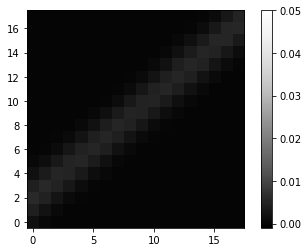

In [22]:
plt.imshow(prefit_crop, origin='lower',cmap='Greys_r', vmin=-0.001, vmax=0.05)
plt.colorbar()
plt.show()

In [23]:
# define extra parameters needed for model fitting

#model.xss = xss_crop #arc
#model.yss = yss_crop
model.xss = xss_hires #star
model.yss = yss_hires
model.xlo = xlo#2650
model.xhi = xhi#3100
model.ylo = ylo#1800
model.yhi = yhi#2100

model.arcim = imdata[ylo:yhi, xlo:xhi] #star
#model.arcim = imcopy[ylo:yhi, xlo:xhi] #arc, subtracted
model.simim = np.zeros_like(model.arcim)
model.simim += prefit_crop
model.resolution = 'high' # 'high', 'mixed', or 'standard'

star_positions = [(2231, 1622), # 1622
                  (2541, 3475), # 136
                  (2163, 2913), # 593
                  (3535, 1560), # 1677
                  (2864, 2477), # 898
                  (1724, 2667),] # 778

model.set_psf(style='list', star_imdata=imdata, pos_list=star_positions, extent=11)

rmsfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_rms.fits'
rmsfile = os.path.join(indir, rmsfile)
model.set_sigma(rmsfile=rmsfile, exp_time=5123.501098)

In [24]:
if model.resolution == 'mixed':
    xlo_star, xhi_star = 2945, 2990
    ylo_star, yhi_star = 1970, 2015
    #xlo_star, xhi_star = xe-1, xe+1
    #ylo_star, yhi_star = ye-1, ye+1

    model.init_mixed_resolution(0.001,#0.01, 
                                xlo_star, xhi_star, 
                                ylo_star, yhi_star, 
                                xx_crop, yy_crop, 
                                ax_crop, ay_crop)

    model.hires_im = imdata[ylo_star:yhi_star,xlo_star:xhi_star]
    plt.imshow(model.hires_im,origin='lower')

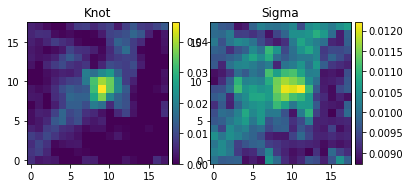

In [25]:
#sanity check: plot model arc, sigma

fig, ([ax1, ax2]) = plt.subplots(1,2)

im1 = ax1.imshow(model.arcim, origin='lower')
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('Knot')

im2 = ax2.imshow(model.sigma, origin='lower')
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Sigma')

plt.show()

In [16]:
init = np.array([1000., 0.0001])#, 1., 1.])
fit = model.min_fit(init)
print(fit)

 final_simplex: (array([[4.22933665e+03, 5.00000520e-05],
       [4.22933665e+03, 5.00000520e-05],
       [4.22933673e+03, 5.00000520e-05]]), array([-217.45075989, -217.45075989, -217.45075989]))
           fun: -217.4507598876953
       message: 'Optimization terminated successfully.'
          nfev: 206
           nit: 100
        status: 0
       success: True
             x: array([4.22933665e+03, 5.00000520e-05])


In [43]:
mcmcfile = 'whl0137/knots/knotfit_chains/star/ltm_rcut2e-5_3000step.h5'
sampler, autocorr, index = model.runMCMC(fit.x,
                                         niter=3000,
                                         nwalkers=12,
                                         full_output=True,
                                         #multiprocess=True,
                                         #n_core=4,
                                         outfile=mcmcfile)

100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]


In [26]:
mcmcfile = 'whl0137/knots/knotfit_chains/star/ltm_rcut2e-5_3000step.h5'
reader = emcee.backends.HDFBackend(mcmcfile)
samples = reader.get_chain(discard=100,flat=True)
lprob = reader.get_log_prob(discard=100,flat=True)

#samples = sampler.get_chain(discard=100, flat=True)
#lprob = sampler.get_log_prob(discard=100, flat=True)

amp = samples[:,0]
reff = samples[:,1]
#n = samples[:,2]

ix = tuple([lprob == max(lprob)])
rmax = reff[ix]
amax = amp[ix]
#nmax = n[ix]

sigr_plus = np.percentile(reff, 84)
sigr_minus = np.percentile(reff, 16)
sigr = (sigr_plus - sigr_minus) / 2.

siga_plus = np.percentile(amp, 84)
siga_minus = np.percentile(amp, 16)
siga = (siga_plus - siga_minus) / 2.

#sign_plus = np.percentile(n, 84)
#sign_minus = np.percentile(n, 16)
#sign = (sign_plus - sign_minus) / 2.


print('Radius: %.2e (%.2e) +- %.2e' %(rmax[0], np.median(reff), sigr))
print('Amplitude: %.4f (%.4f) +- %.4f' %(amax[0], np.median(amp), siga))
#print('Sersic index: %.2f (%.2f) +- %.2f' %(nmax[0], np.median(n), sign))
print('Radius (pc): %.2e (%.2e) +- %.2e' %(pix_to_pc(rmax[0], 6.2),
                                           pix_to_pc(np.median(reff), 6.2),
                                           pix_to_pc(sigr,6.2)))

Radius: 7.35e-05 (6.07e-05) +- 2.89e-05
Amplitude: 3386.3132 (4048.0048) +- 1608.4338
Radius (pc): 2.47e-02 (2.04e-02) +- 9.72e-03


[4048.0048325273124, 6.067406025505157e-05]


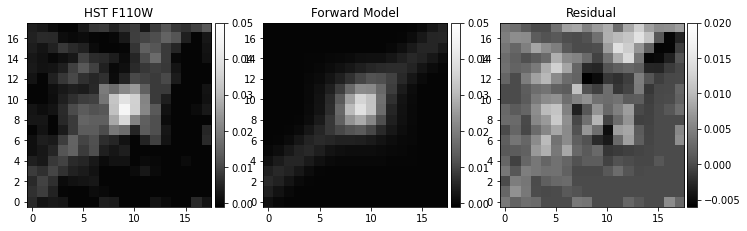

58.146492


In [27]:
#sanity check: plot relensed arc w/ fit params, see if it looks right
#theta = fit.x
theta = [np.median(samples[:,0]), np.median(samples[:,1])]#, np.median(samples[:,2]), np.median(samples[:,3])]

print(theta)

cv = model.convolved(theta)
arcimage = np.copy(imdata[ylo:yhi, xlo:xhi]) #np.copy(model.arcim) 

simimage =  np.copy(model.simim) # np.zeros_like(arcimage) 
simimage[:,:] += cv[:,:]

Xsq = model.chisquared(theta)
diff = arcimage - simimage


fig, ([ax1, ax2, ax4]) = plt.subplots(1, 3, figsize=(12,6))


im1 = ax1.imshow(arcimage, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.05)#, norm=norm)#)##)

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('HST F110W')
#ax1.set_xticks([])
#ax1.set_yticks([])

im2 = ax2.imshow(simimage, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.05)#, norm=norm2)#)##)

div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Forward Model')
#ax2.set_xticks([])
#ax2.set_yticks([])

im4 = ax4.imshow(diff, origin='lower', cmap='Greys_r', vmin=-0.006, vmax=0.02)

div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical')
ax4.set_title('Residual')
#ax4.set_xticks([])
#ax4.set_yticks([])


#plt.savefig('whl0137/starpaper/plots/arc_fit_resid2.pdf',
#            bbox_inches='tight',pad_inches=0)

plt.show()

print(np.sum(Xsq))

In [28]:
PHOTFNU = 6.7784441E-08 # Inverse sensitivity, Jy*sec/e-

flux = amp * 2 * np.pi * reff**2
print(np.median(flux),np.std(flux))
flux_nJy = flux * PHOTFNU * 1e9
print(np.median(flux_nJy), np.std(flux_nJy))
ratio = flux_nJy / 120.
SFR = ratio * 80 # Msun/yr

print("SFR = %.3e +- %.3e" %(np.median(SFR), np.std(SFR)))

image_flux = 48.79 
image_flux_err = 4.1241
obj_magnif = image_flux / np.median(flux_nJy)
magnif_err_relative = np.sqrt((image_flux_err / image_flux)**2 + (np.std(flux_nJy) / np.median(flux_nJy))**2)
magnif_err = magnif_err_relative * obj_magnif
print("Magnification from Flux: %.2f +- %.2f" %(obj_magnif, magnif_err))

9.289078132281152e-05 4.3671447758794786e-05
0.00629654968602002 0.0029602446739906076
SFR = 4.198e-03 +- 1.973e-03
Magnification from Flux: 7748.69 +- 3701.36


In [29]:
full_magnif = image_flux / flux_nJy

log_mag = np.log10(full_magnif)
print(np.median(log_mag), np.std(log_mag))
print(np.median(full_magnif), np.std(full_magnif))
print()
print(min(full_magnif), max(full_magnif))
#print(1. / magnifinv[ye,xe])

3.889228183388855 0.2607177884133404
7748.688159854675 8837.539539969242

3314.910547988542 61221.68756103469


In [30]:
n_sigma = 1
confidence = sp.erf(n_sigma / np.sqrt(2))
low_percentile = 100 * (1 - confidence) / 2.
hi_percentile = 100 - low_percentile
percentiles = np.percentile(log_mag, (low_percentile, 50, hi_percentile))
print(percentiles)

err_low = percentiles[1] - percentiles[0]
err_hi = percentiles[2] - percentiles[1]

print("Log(Magnification) = %.2f (+ %.2f) (- %.2f)" %(percentiles[1],err_hi,err_low))
print("Magnification = %.2f (+%.2f) (-%.2f)" 
      %(10**percentiles[1],
        (10**percentiles[2] - 10**percentiles[1]),
         (10**percentiles[1] - 10**percentiles[0])))
print(max(full_magnif))

[3.70815641 3.88922818 4.23649412]
Log(Magnification) = 3.89 (+ 0.35) (- 0.18)
Magnification = 7748.69 (+9489.60) (-2641.80)
61221.68756103469


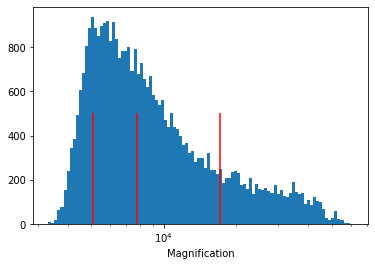

In [31]:
# magnification histogram
logmin, logmax = np.log10(min(full_magnif)), np.log10(max(full_magnif))
logbins = np.logspace(logmin, logmax, num=101)

plt.hist(full_magnif, bins=logbins)#, log=True)
plt.xscale('log')
plt.xlabel('Magnification')
plt.vlines(10**percentiles,0,500, colors='r')
#plt.xlim(1e3,1e7)
plt.show()

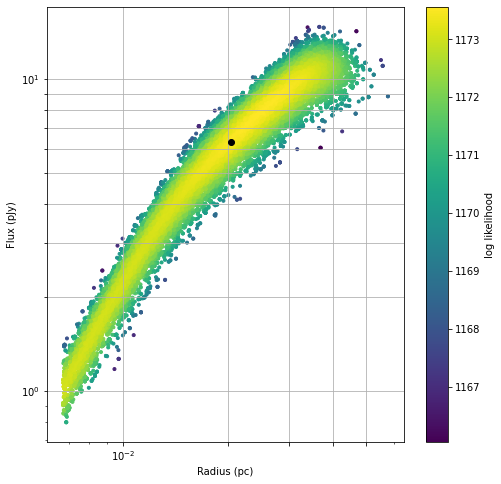

In [34]:
r_parsecs = pix_to_pc(reff, 6.2)
fluxes = (amp * 2 * np.pi * reff**2) * (PHOTFNU * 1e9)

fig = plt.figure(figsize=(8,8))

#plt.scatter(reff, amp, c=lprob, marker='.')
plt.scatter(r_parsecs, fluxes*1e3, c=lprob, marker='.')
#plt.plot(pix_to_pc(rmax, 6.2), amax*2*np.pi*rmax**2*1e3, 'ro')
plt.plot(np.median(r_parsecs), np.median(fluxes)*1e3, 'ko')
#plt.plot(8, 0.05, 'kx')
cb = plt.colorbar(label='log likelihood')
#plt.plot(450, 0.0007, 'ro')
plt.loglog()
#plt.xlabel('R_eff (pixels)')
#plt.ylabel('Amplitude')
plt.xlabel('Radius (pc)')
plt.ylabel('Flux (pJy)')#forward
plt.yticks(np.linspace(1,10,10))
plt.xticks(np.linspace(0.01,0.05,5))
plt.grid(True)

#plt.savefig('knotfit/chains/whl0137/lowknot_sersic+gauss_AvsR_log.png')
plt.show()

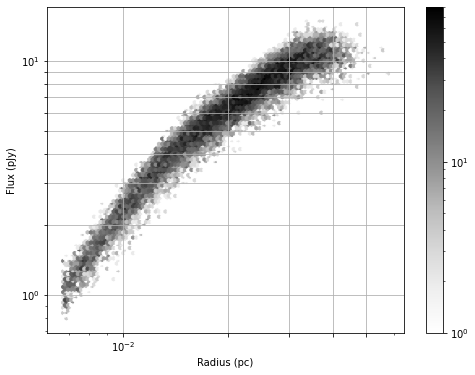

In [35]:
fig = plt.figure(figsize=(8,6))
plt.hexbin(r_parsecs, fluxes*1e3, xscale='log',yscale='log',bins='log',cmap='Greys')
cb = plt.colorbar()
plt.xlabel('Radius (pc)')
plt.ylabel('Flux (pJy)')
plt.yticks(np.linspace(1,10,10))
plt.xticks(np.linspace(0.01,0.05,5))
plt.grid(True)
plt.show()

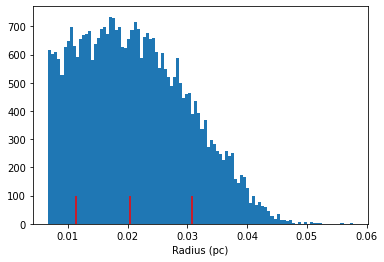

[0.01133743 0.02041768 0.03077365 0.03716174 0.04227004]


In [36]:
plt.hist(r_parsecs, bins=100)
plt.vlines(np.percentile(r_parsecs,(16,50,84)),0,100,colors='r')
plt.xlabel('Radius (pc)')
plt.show()

print(np.percentile(r_parsecs,(16,50,84,95,99)))
#np.percentile(reff[reff>3e-5], 95)

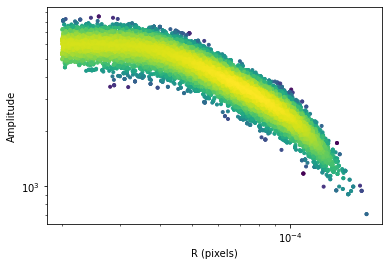

In [37]:
plt.scatter(reff, amp, c=lprob, marker='.')
plt.xlabel('R (pixels)')
plt.ylabel('Amplitude')
plt.loglog()
plt.show()
#print(len(reff[reff>3e-5]),len(reff))

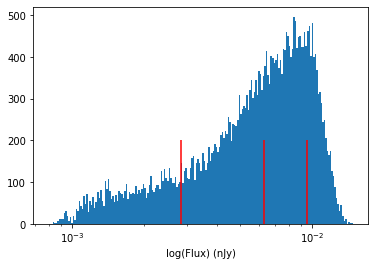

[0.0015164  0.00284325 0.00629655 0.00954223 0.01102112 0.01232102]
log(Flux) (nJy) = -2.20 +(0.18) -(0.35)
Flux (pJy) = 6.30 (+3.25) (-3.45)
6.29654968602002 2.9602446739906076


In [38]:
log_flux = np.log10(flux_nJy)
logmin, logmax = np.log10(min(flux_nJy)), np.log10(max(flux_nJy))
logbins = np.logspace(logmin, logmax, num=201)

plt.hist(flux_nJy, bins=logbins)
plt.vlines(np.percentile(flux_nJy,(16,50,84)),0,200,colors='r')
plt.xscale('log')
plt.xlabel('log(Flux) (nJy)')
#plt.xlim(1e-6,0.1)
plt.show()

flux_percentiles = np.percentile(log_flux, (16,50,84))
flux_err_hi = flux_percentiles[2] - flux_percentiles[1]
flux_err_lo = flux_percentiles[1] - flux_percentiles[0]

print(np.percentile(flux_nJy,(5,16,50,84,95,99)))
print("log(Flux) (nJy) = %.2f +(%.2f) -(%.2f)" %(flux_percentiles[1],flux_err_hi,flux_err_lo))
print("Flux (pJy) = %.2f (+%.2f) (-%.2f)" 
     %(10**flux_percentiles[1] * 1e3, 
       (10**flux_percentiles[2] - 10**flux_percentiles[1]) * 1e3,
      (10**flux_percentiles[1] - 10**flux_percentiles[0]) * 1e3))
print(np.median(flux_nJy)*1e3, np.std(flux_nJy)*1e3)

In [39]:
def flux_to_mag(f_nJy):
    # assumes flux in nJy
    return 31.4 - 2.5 * np.log10(f_nJy)

def app_to_abs(mag, d_pc):
    return mag - (5*np.log10(d_pc)) + 5

mags = flux_to_mag(flux_nJy)

mag_percentiles = np.percentile(mags,(16,50,84))
print(mag_percentiles)
print(np.median(mags),np.std(mags))

mag_err_hi = mag_percentiles[2] - mag_percentiles[1]
mag_err_lo = mag_percentiles[1] - mag_percentiles[0]

print("m_AB = %.2f +(%.2f) -(%.2f)" %(mag_percentiles[1],mag_err_hi,mag_err_lo))

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dist6p2 = cosmo.luminosity_distance(6.2).value
dist6p2 *= 1e6
abs_mags = app_to_abs(mags, dist6p2)
abs_mag_percentiles = np.percentile(abs_mags,(16,50,84))
print(abs_mag_percentiles)
print(np.median(abs_mags),np.std(abs_mags))

abs_mag_err_hi = abs_mag_percentiles[2] - abs_mag_percentiles[1]
abs_mag_err_lo = abs_mag_percentiles[1] - abs_mag_percentiles[0]

print("M = %.2f +(%.2f) -(%.2f)" %(abs_mag_percentiles[1],abs_mag_err_hi,abs_mag_err_lo))


[36.45087504 36.90224341 37.76546292]
36.90224341319147 0.6517944710333511
m_AB = 36.90 +(0.86) -(0.45)
[-12.43883614 -11.98746776 -11.12424826]
-11.98746775874185 0.651794471033351
M = -11.99 +(0.86) -(0.45)
